### Needed imports

In [1]:
%matplotlib inline
import cv2 
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc 
import glob
import sys


## Calibration Data


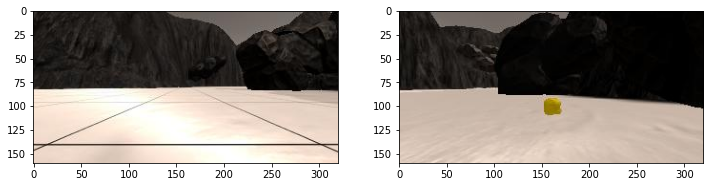

In [2]:
example_grid = '../calibration_images/example_grid1.jpg'
example_rock = '../calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

## Perspective Transform


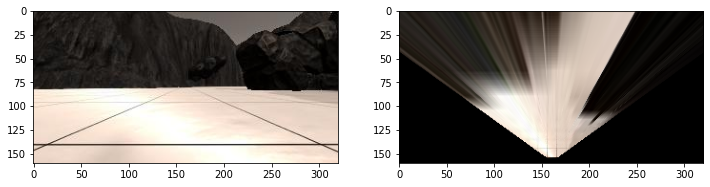

In [3]:
def perspect_transform(img, src, dst):      
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    
    return warped


path = '../test_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
# plt.imshow(image)


dst_size = 5 
bottom_offset = 6

source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])

destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])

warped = perspect_transform(grid_img, source, destination)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(warped)

## Color Thresholding


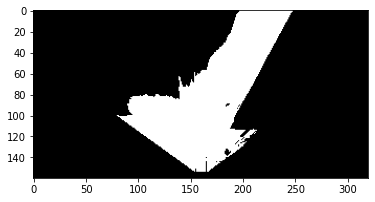

In [4]:
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    color_select = np.zeros_like(img[:,:,0])
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    color_select[above_thresh] = 1
    return color_select

threshed = color_thresh(warped)
plt.imshow(threshed, cmap='gray')

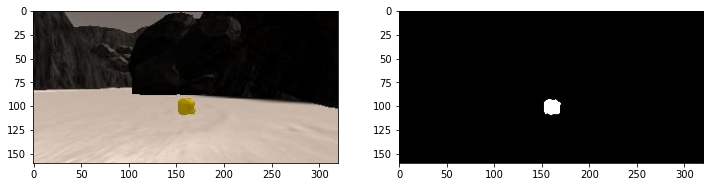

In [5]:
def thresh_rock(img):
    remove_mountain = np.zeros_like(img[:,:,:])
    rgb_thresh = (100,100,0)
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    for idx, x in np.ndenumerate(remove_mountain):
        if above_thresh[idx[0], idx[1]] == 1:
            remove_mountain[idx[0], idx[1]] = img[idx[0], idx[1]]
    rgb_thresh = (100,100,50)
    rock_select = np.zeros_like(remove_mountain[:,:,0])
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] < rgb_thresh[2])
    rock_select[above_thresh] = 1
    return rock_select
        
example_rock = '../calibration_images/example_rock1.jpg'
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(rock_img)
plt.subplot(122)
plt.imshow(thresh_rock(rock_img), cmap="gray")

## Coordinate Transformations


True


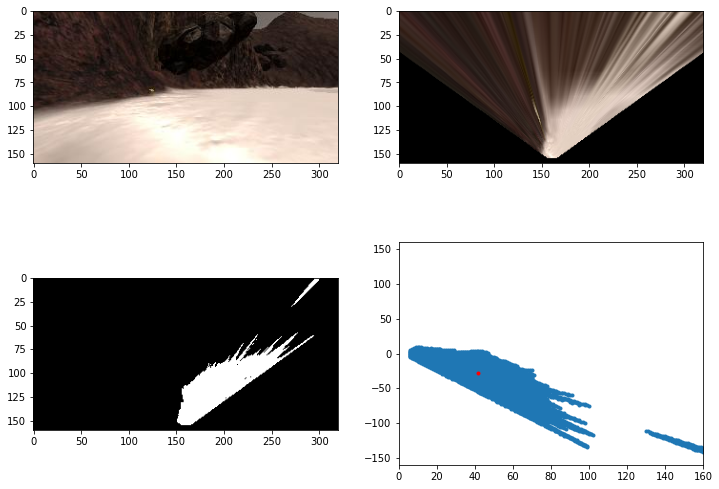

In [6]:
def rover_coords(binary_img):
    ypos, xpos = binary_img.nonzero()
    x_pixel = -(ypos - binary_img.shape[0])
    y_pixel = -(xpos - binary_img.shape[1]/2 )

    return x_pixel, y_pixel

def to_polar_coords(x_pixel, y_pixel):
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

def rotate_pix(xpix, ypix, yaw):
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    return xpix_translated, ypix_translated


def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    return x_pix_world, y_pix_world

idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped = perspect_transform(image, source, destination)
threshed = color_thresh(warped)

xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)


fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 50
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.plot(x_arrow, y_arrow, '.r')

def findCoord(x, y, xpix, ypix):
    x = int(x)
    y = int(y)
    for idx, i in np.ndenumerate(xpix):
        if x == i and y == int(ypix[idx]):
            return True
    return False

print(findCoord(x_arrow, y_arrow, xpix, ypix))


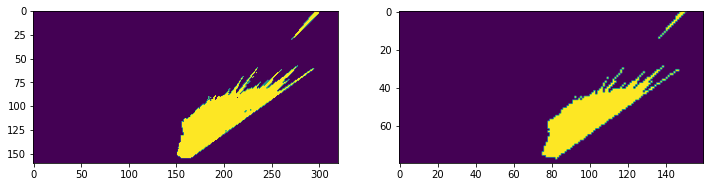

In [7]:
def scale_img(img, scale):
    res = cv2.resize(img, dsize=(int(img.shape[1]/scale), int(img.shape[0]/scale)), interpolation=cv2.INTER_CUBIC)
    return res
fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(threshed)
plt.subplot(122)
plt.imshow(scale_img(threshed, 2))